In [1]:
# Import libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
class ANN3layer:

    def __init__(self, X, y, dataset):
        self.dataset = dataset
        self.X = np.array(X)
        self.y = np.array(y)
        self.y = self.y.reshape(self.y.shape[0],)

    def label_encoder(self):
        le = LabelEncoder()
        le.fit(np.unique(self.y))
        self.y = le.transform(self.y)
        self.y = to_categorical(self.y)

        return self.y

    def flatten_dims(self):
        self.X = self.X.reshape(self.X.shape[0], -1)
        self.y = self.y.reshape(self.y.shape[0], -1)
        return self.X, self.y

    def preprocessing(self):
        x_train, x_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=101)
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        y_test = np.argmax(y_test, axis=1).reshape(y_test.shape[0], -1)

        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

        return self.x_train, self.x_test, self.y_train, self.y_test

    def nn_architecture(self):
        w_1s = np.random.uniform(-1, 1, size=(12, 16))
        b_1s = np.array([1] * 12).reshape(1, 12)
        nn_1 = [w_1s, b_1s]

        w_2s = np.random.uniform(-1, 1, size=(24, 12))
        b_2s = np.array([1] * 24).reshape(1, 24)
        nn_2 = [w_2s, b_2s]

        w_3s = np.random.uniform(-1, 1, size=(7, 24))
        b_3s = np.array([1] * 7).reshape(1, 7)
        nn_3 = [w_3s, b_3s]

        self.nn_1 = nn_1
        self.nn_2 = nn_2
        self.nn_3 = nn_3

        return self.nn_1, self.nn_2, self.nn_3

    def leaky_relu(self, value, alpha=0.01):
        return np.where(value > 0, value, alpha * value)

    def leaky_relu_derivative(self, value, alpha=0.01):
        return np.where(value > 0, 1, alpha)

    def sigmoid(self, value):
        return 1 / (1 + np.exp(-value))

    def sigmoid_derivative(self, value):
        return self.sigmoid(value) * (1 - self.sigmoid(value))

    def forward_prop(self, data_set):
        # Forward propagation
        z_1 = np.dot(self.nn_1[0], data_set.T) + self.nn_1[1].T
        a_1 = self.leaky_relu(z_1)
        nn_1f = [z_1, a_1]

        z_2 = np.dot(self.nn_2[0], a_1) + self.nn_2[1].T
        a_2 = self.leaky_relu(z_2)
        nn_2f = [z_2, a_2]

        z_3 = np.dot(self.nn_3[0], a_2) + self.nn_3[1].T
        a_3 = self.sigmoid(z_3)
        nn_3f = [z_3, a_3]

        self.nn_1f = nn_1f
        self.nn_2f = nn_2f
        self.nn_3f = nn_3f

        return self.nn_1f, self.nn_2f, self.nn_3f

    def cost_function(self, pred_labels, true_labels):
        epsilon = np.power(0.1, 5)
        preds = np.clip(pred_labels, epsilon, 1.0 - epsilon)
        J = (-np.sum(true_labels.T * np.log(pred_labels) + (1 - true_labels.T) * np.log(1 - pred_labels))) / len(true_labels)
        return J

    def back_prop(self):
        dz_3 = self.nn_3f[1].T - self.y_train
        dw_3 = np.dot(dz_3.T, self.nn_2f[1].T)
        db_3 = np.sum(dz_3, axis=0).T
        nn_3b = [dw_3 / len((self.y_train)), db_3 / len((self.y_train))]

        dz_2 = np.dot(self.nn_3[1], dz_3.T) * (self.leaky_relu_derivative(self.nn_2f[0]))
        dw_2 = np.dot(dz_2, self.nn_1f[1].T)
        db_2 = np.sum(dz_2.T, axis=0)
        nn_2b = [dw_2 / len((self.y_train)), db_2 / (len(self.y_train))]

        dz_1 = np.dot(self.nn_2[1], dz_2) * (self.leaky_relu_derivative(self.nn_1f[0]))
        dw_1 = np.dot(dz_1, self.x_train)
        db_1 = np.sum(dz_1.T, axis=0)
        nn_1b = [dw_1 / (len(self.y_train)), db_1 / (len(self.y_train))]

        self.nn_3b = nn_3b
        self.nn_2b = nn_2b
        self.nn_1b = nn_1b

        return self.nn_1b, self.nn_2b, self.nn_3b

    def gradient_descent(self, learning_rate):
        self.nn_1[0] = self.nn_1[0] - learning_rate * self.nn_1b[0]
        self.nn_1[1] = self.nn_1[1] - learning_rate * self.nn_1b[1]
        self.nn_2[0] = self.nn_2[0] - learning_rate * self.nn_2b[0]
        self.nn_2[1] = self.nn_2[1] - learning_rate * self.nn_2b[1]
        self.nn_3[0] = self.nn_3[0] - learning_rate * self.nn_3b[0]
        self.nn_3[1] = self.nn_3[1] - learning_rate * self.nn_3b[1]

        return self.nn_1, self.nn_2, self.nn_3

    def predict_labels(self, data_set):
        temp_arr = []
        z_1 = np.dot(self.nn_1[0], data_set.T) + self.nn_1[1].T
        a_1 = self.leaky_relu(z_1)

        z_2 = np.dot(self.nn_2[0], a_1) + self.nn_2[1].T
        a_2 = self.leaky_relu(z_2)

        z_3 = np.dot(self.nn_3[0], a_2) + self.nn_3[1].T
        a_3 = self.sigmoid(z_3).T

        for i in range(len(a_3)):
            temp_arr.append(np.argmax(a_3[i]))
        temp_arr = np.array(temp_arr)
        self.preds = temp_arr.reshape(temp_arr.shape[0], -1)

        return self.preds

    def accuracy_score(self):
        acc = 0
        for i in range(len(self.preds)):
            if self.preds[i][0] == self.y_test[i][0]:
                acc += 1
            else:
                pass

        return acc / len(self.preds)

In [3]:
# Define hyperparameters
num_epochs = 1000
learning_rate = 0.1
cost_train = []
cost_val = []

# Load dataset
dry_bean_dataset = fetch_ucirepo(id=602)
X = dry_bean_dataset.data.features
y = dry_bean_dataset.data.targets

# Initialize neural network
nn = ANN3layer(X, y, dry_bean_dataset)
y_encoded = nn.label_encoder()
nn.flatten_dims()
nn.preprocessing()
nn_1, nn_2, nn_3 = nn.nn_architecture()

# Training loop
for epoch in range(num_epochs):
    # Forward propagation on training set
    nn_1f, nn_2f, nn_3f = nn.forward_prop(nn.x_train)
    # Compute training cost
    cost_train_epoch = nn.cost_function(nn_3f[1], nn.y_train)
    cost_train.append(cost_train_epoch)

    # Backpropagation
    nn_1b, nn_2b, nn_3b = nn.back_prop()
    nn_1, nn_2, nn_3 = nn.gradient_descent(learning_rate)
    learning_rate *= 0.99

    # Forward propagation on validation set
    nn_1ft, nn_2ft, nn_3ft = nn.forward_prop(nn.x_test)
    # Compute validation cost
    cost_val_epoch = nn.cost_function(nn_3ft[1], nn.y_test)
    cost_val.append(cost_val_epoch)

    # Logging
    print(f"Epoch {epoch + 1}/{num_epochs} | Training Cost: {cost_train_epoch:.6f} | Validation Cost: {cost_val_epoch:.6f}")

print(f"Final Training Cost: {cost_train[-1]:.6f}")
print(f"Final Validation Cost: {cost_val[-1]:.6f}")

Epoch 1/1000 | Training Cost: nan | Validation Cost: -0.812164
Epoch 2/1000 | Training Cost: 8.246937 | Validation Cost: -13.676898
Epoch 3/1000 | Training Cost: 7.699859 | Validation Cost: -12.977778
Epoch 4/1000 | Training Cost: 7.516904 | Validation Cost: -11.533738
Epoch 5/1000 | Training Cost: 7.233333 | Validation Cost: -9.900627
Epoch 6/1000 | Training Cost: 6.918889 | Validation Cost: -8.074539
Epoch 7/1000 | Training Cost: 6.606625 | Validation Cost: -6.636081
Epoch 8/1000 | Training Cost: 6.365460 | Validation Cost: -6.043928
Epoch 9/1000 | Training Cost: 6.216375 | Validation Cost: -6.002191
Epoch 10/1000 | Training Cost: 6.149087 | Validation Cost: -6.044450
Epoch 11/1000 | Training Cost: 6.118079 | Validation Cost: -5.854939
Epoch 12/1000 | Training Cost: 6.080212 | Validation Cost: -5.502065
Epoch 13/1000 | Training Cost: 6.030620 | Validation Cost: -5.084042
Epoch 14/1000 | Training Cost: 5.974021 | Validation Cost: -4.547027
Epoch 15/1000 | Training Cost: 5.898470 | Val

Epoch 121/1000 | Training Cost: 2.761669 | Validation Cost: 64.146652
Epoch 122/1000 | Training Cost: 2.659522 | Validation Cost: 69.809556
Epoch 123/1000 | Training Cost: 2.520534 | Validation Cost: 75.121757
Epoch 124/1000 | Training Cost: 2.403633 | Validation Cost: 79.529584
Epoch 125/1000 | Training Cost: 2.338429 | Validation Cost: 82.568607
Epoch 126/1000 | Training Cost: 2.306833 | Validation Cost: 84.810123
Epoch 127/1000 | Training Cost: 2.283149 | Validation Cost: 86.868009
Epoch 128/1000 | Training Cost: 2.261491 | Validation Cost: 88.843299
Epoch 129/1000 | Training Cost: 2.240656 | Validation Cost: 90.726674
Epoch 130/1000 | Training Cost: 2.220147 | Validation Cost: 92.512624
Epoch 131/1000 | Training Cost: 2.200046 | Validation Cost: 94.209942
Epoch 132/1000 | Training Cost: 2.180128 | Validation Cost: 95.825572
Epoch 133/1000 | Training Cost: 2.160719 | Validation Cost: 97.355872
Epoch 134/1000 | Training Cost: 2.141735 | Validation Cost: 98.828510
Epoch 135/1000 | Tra

Epoch 237/1000 | Training Cost: 1.793412 | Validation Cost: 148.647702
Epoch 238/1000 | Training Cost: 1.793023 | Validation Cost: 149.006208
Epoch 239/1000 | Training Cost: 1.792670 | Validation Cost: 149.366060
Epoch 240/1000 | Training Cost: 1.792328 | Validation Cost: 149.726613
Epoch 241/1000 | Training Cost: 1.792004 | Validation Cost: 150.088465
Epoch 242/1000 | Training Cost: 1.791665 | Validation Cost: 150.450718
Epoch 243/1000 | Training Cost: 1.791362 | Validation Cost: 150.813335
Epoch 244/1000 | Training Cost: 1.791085 | Validation Cost: 151.176275
Epoch 245/1000 | Training Cost: 1.790835 | Validation Cost: 151.540158
Epoch 246/1000 | Training Cost: 1.790592 | Validation Cost: 151.904713
Epoch 247/1000 | Training Cost: 1.790356 | Validation Cost: 152.269189
Epoch 248/1000 | Training Cost: 1.790174 | Validation Cost: 152.633809
Epoch 249/1000 | Training Cost: 1.789990 | Validation Cost: 152.998984
Epoch 250/1000 | Training Cost: 1.789816 | Validation Cost: 153.364447
Epoch 

Epoch 355/1000 | Training Cost: 1.757640 | Validation Cost: 187.040522
Epoch 356/1000 | Training Cost: 1.757404 | Validation Cost: 187.244754
Epoch 357/1000 | Training Cost: 1.757175 | Validation Cost: 187.446711
Epoch 358/1000 | Training Cost: 1.756958 | Validation Cost: 187.646296
Epoch 359/1000 | Training Cost: 1.756758 | Validation Cost: 187.843467
Epoch 360/1000 | Training Cost: 1.756565 | Validation Cost: 188.038304
Epoch 361/1000 | Training Cost: 1.756384 | Validation Cost: 188.230768
Epoch 362/1000 | Training Cost: 1.756206 | Validation Cost: 188.421165
Epoch 363/1000 | Training Cost: 1.756041 | Validation Cost: 188.609388
Epoch 364/1000 | Training Cost: 1.755886 | Validation Cost: 188.795472
Epoch 365/1000 | Training Cost: 1.755740 | Validation Cost: 188.979331
Epoch 366/1000 | Training Cost: 1.755604 | Validation Cost: 189.161066
Epoch 367/1000 | Training Cost: 1.755479 | Validation Cost: 189.340512
Epoch 368/1000 | Training Cost: 1.755363 | Validation Cost: 189.517952
Epoch 

Epoch 472/1000 | Training Cost: 1.771096 | Validation Cost: 200.604579
Epoch 473/1000 | Training Cost: 1.771336 | Validation Cost: 200.666739
Epoch 474/1000 | Training Cost: 1.771574 | Validation Cost: 200.728392
Epoch 475/1000 | Training Cost: 1.771812 | Validation Cost: 200.789527
Epoch 476/1000 | Training Cost: 1.772048 | Validation Cost: 200.850087
Epoch 477/1000 | Training Cost: 1.772283 | Validation Cost: 200.910128
Epoch 478/1000 | Training Cost: 1.772516 | Validation Cost: 200.969691
Epoch 479/1000 | Training Cost: 1.772748 | Validation Cost: 201.028747
Epoch 480/1000 | Training Cost: 1.772980 | Validation Cost: 201.087286
Epoch 481/1000 | Training Cost: 1.773209 | Validation Cost: 201.145364
Epoch 482/1000 | Training Cost: 1.773438 | Validation Cost: 201.202975
Epoch 483/1000 | Training Cost: 1.773667 | Validation Cost: 201.260129
Epoch 484/1000 | Training Cost: 1.773894 | Validation Cost: 201.316807
Epoch 485/1000 | Training Cost: 1.774120 | Validation Cost: 201.373005
Epoch 

Epoch 601/1000 | Training Cost: 1.791556 | Validation Cost: 205.380023
Epoch 602/1000 | Training Cost: 1.791639 | Validation Cost: 205.399060
Epoch 603/1000 | Training Cost: 1.791721 | Validation Cost: 205.417915
Epoch 604/1000 | Training Cost: 1.791803 | Validation Cost: 205.436580
Epoch 605/1000 | Training Cost: 1.791883 | Validation Cost: 205.455063
Epoch 606/1000 | Training Cost: 1.791962 | Validation Cost: 205.473399
Epoch 607/1000 | Training Cost: 1.792040 | Validation Cost: 205.491560
Epoch 608/1000 | Training Cost: 1.792118 | Validation Cost: 205.509550
Epoch 609/1000 | Training Cost: 1.792194 | Validation Cost: 205.527368
Epoch 610/1000 | Training Cost: 1.792270 | Validation Cost: 205.545003
Epoch 611/1000 | Training Cost: 1.792346 | Validation Cost: 205.562463
Epoch 612/1000 | Training Cost: 1.792420 | Validation Cost: 205.579745
Epoch 613/1000 | Training Cost: 1.792494 | Validation Cost: 205.596858
Epoch 614/1000 | Training Cost: 1.792567 | Validation Cost: 205.613811
Epoch 

Epoch 732/1000 | Training Cost: 1.797632 | Validation Cost: 206.791469
Epoch 733/1000 | Training Cost: 1.797654 | Validation Cost: 206.796717
Epoch 734/1000 | Training Cost: 1.797676 | Validation Cost: 206.801913
Epoch 735/1000 | Training Cost: 1.797698 | Validation Cost: 206.807058
Epoch 736/1000 | Training Cost: 1.797720 | Validation Cost: 206.812152
Epoch 737/1000 | Training Cost: 1.797741 | Validation Cost: 206.817195
Epoch 738/1000 | Training Cost: 1.797763 | Validation Cost: 206.822187
Epoch 739/1000 | Training Cost: 1.797784 | Validation Cost: 206.827131
Epoch 740/1000 | Training Cost: 1.797804 | Validation Cost: 206.832025
Epoch 741/1000 | Training Cost: 1.797825 | Validation Cost: 206.836872
Epoch 742/1000 | Training Cost: 1.797845 | Validation Cost: 206.841671
Epoch 743/1000 | Training Cost: 1.797866 | Validation Cost: 206.846422
Epoch 744/1000 | Training Cost: 1.797886 | Validation Cost: 206.851127
Epoch 745/1000 | Training Cost: 1.797905 | Validation Cost: 206.855785
Epoch 

Epoch 863/1000 | Training Cost: 1.799271 | Validation Cost: 207.177332
Epoch 864/1000 | Training Cost: 1.799277 | Validation Cost: 207.178751
Epoch 865/1000 | Training Cost: 1.799283 | Validation Cost: 207.180156
Epoch 866/1000 | Training Cost: 1.799289 | Validation Cost: 207.181546
Epoch 867/1000 | Training Cost: 1.799295 | Validation Cost: 207.182923
Epoch 868/1000 | Training Cost: 1.799300 | Validation Cost: 207.184286
Epoch 869/1000 | Training Cost: 1.799306 | Validation Cost: 207.185635
Epoch 870/1000 | Training Cost: 1.799312 | Validation Cost: 207.186972
Epoch 871/1000 | Training Cost: 1.799317 | Validation Cost: 207.188294
Epoch 872/1000 | Training Cost: 1.799323 | Validation Cost: 207.189604
Epoch 873/1000 | Training Cost: 1.799328 | Validation Cost: 207.190900
Epoch 874/1000 | Training Cost: 1.799334 | Validation Cost: 207.192184
Epoch 875/1000 | Training Cost: 1.799339 | Validation Cost: 207.193455
Epoch 876/1000 | Training Cost: 1.799345 | Validation Cost: 207.194713
Epoch 

Epoch 979/1000 | Training Cost: 1.799686 | Validation Cost: 207.275084
Epoch 980/1000 | Training Cost: 1.799688 | Validation Cost: 207.275526
Epoch 981/1000 | Training Cost: 1.799689 | Validation Cost: 207.275965
Epoch 982/1000 | Training Cost: 1.799691 | Validation Cost: 207.276398
Epoch 983/1000 | Training Cost: 1.799693 | Validation Cost: 207.276828
Epoch 984/1000 | Training Cost: 1.799695 | Validation Cost: 207.277253
Epoch 985/1000 | Training Cost: 1.799697 | Validation Cost: 207.277674
Epoch 986/1000 | Training Cost: 1.799698 | Validation Cost: 207.278091
Epoch 987/1000 | Training Cost: 1.799700 | Validation Cost: 207.278504
Epoch 988/1000 | Training Cost: 1.799702 | Validation Cost: 207.278912
Epoch 989/1000 | Training Cost: 1.799704 | Validation Cost: 207.279317
Epoch 990/1000 | Training Cost: 1.799705 | Validation Cost: 207.279717
Epoch 991/1000 | Training Cost: 1.799707 | Validation Cost: 207.280113
Epoch 992/1000 | Training Cost: 1.799709 | Validation Cost: 207.280506
Epoch 

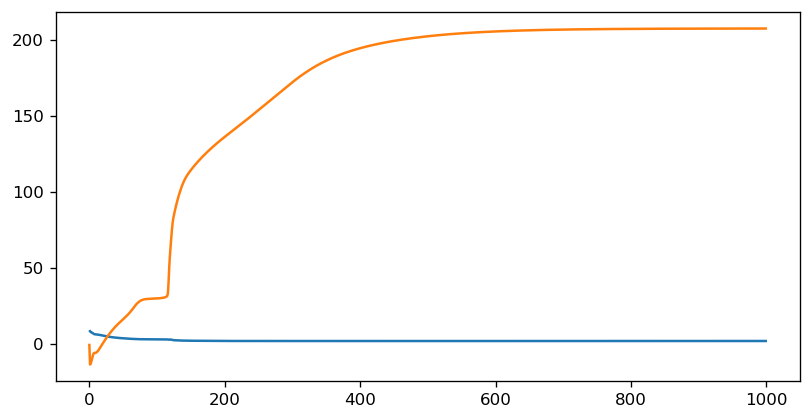

In [4]:
# Plot training & validation cost
plt.figure(figsize=(8,4), dpi=120)
plt.plot(cost_train)
plt.plot(cost_val);

In [5]:
# Accuracy on vaidation dataset
nn.predict_labels(nn.x_test)
nn.accuracy_score()

0.6449559255631734